In [1]:
# MobileSAM "segment everything" (first frame) + XMem propagation (pure Python)
# Local VS Code Jupyter-ready: auto-install deps, auto-download weights, no Colab upload UI

import os, sys, subprocess, json, random, shutil, pathlib, time
import importlib.util

# ----------- Helpers -----------
HERE = pathlib.Path(".").resolve()

def sh(args_list, quiet=True):
    if quiet:
        subprocess.check_call(args_list, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    else:
        subprocess.check_call(args_list)

def ensure_import(pkg_name, pip_name=None, extras=None, quiet=True):
    """
    Try to import pkg_name; if missing, pip install pip_name (or pkg_name).
    extras: list of extra pip args.
    """
    try:
        __import__(pkg_name)
        return
    except Exception:
        pass
    pip_name = pip_name or pkg_name
    cmd = [sys.executable, "-m", "pip", "install", "-q", "--upgrade", pip_name]
    if extras:
        cmd.extend(extras)
    sh(cmd, quiet=quiet)

def ensure_git_clone(repo_url, dest_dir):
    dest = pathlib.Path(dest_dir)
    if not dest.exists():
        sh(["git", "clone", "-q", repo_url, str(dest)])
    return dest

def download_with_retries(urls, out_path, min_mb=10, sleep_s=0.5):
    import urllib.request
    out = pathlib.Path(out_path)
    for url in urls:
        try:
            print(f"Attempting download: {url}")
            urllib.request.urlretrieve(url, str(out))
            sz = out.stat().st_size / (1024 * 1024)
            if sz >= min_mb:
                print(f"Downloaded {out.name} ({sz:.1f} MB)")
                return True
            else:
                print(f"File too small ({sz:.1f} MB); trying next source...")
        except Exception as e:
            print(f"Failed: {e}")
        time.sleep(sleep_s)
    return out.exists() and out.stat().st_size >= min_mb * 1024 * 1024

# ----------- Basic deps -----------
# numpy + opencv
ensure_import("numpy", "numpy")
ensure_import("cv2", "opencv-python")

# torch (if not present)
try:
    import torch  # noqa: F401
except Exception:
    # Basic CPU install; for CUDA, install per local CUDA version if desired
    ensure_import("torch", "torch")

import cv2
import numpy as np
import torch

# ----------- MobileSAM (provides SamAutomaticMaskGenerator) -----------
# Official repo exposes: from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator
try:
    from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator  # noqa: F401
except Exception:
    ensure_import("mobile_sam", "git+https://github.com/ChaoningZhang/MobileSAM.git")
    from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator

# ----------- XMem (pure-Python inference API) -----------
# Clone and install XMem once; its Python modules are imported directly
XMEM_DIR = HERE / "XMem"
ensure_git_clone("https://github.com/hkchengrex/XMem", XMEM_DIR)
# Install XMem requirements (won't downgrade current libs)
try:
    sh([sys.executable, "-m", "pip", "install", "-q", "-r", str(XMEM_DIR / "requirements.txt")])
except Exception:
    # Continue even if some packages are already satisfied
    pass

# Make XMem importable
if str(XMEM_DIR) not in sys.path:
    sys.path.append(str(XMEM_DIR))

# Now import XMem modules
from model.network import XMem as XMemModel              # noqa: E402
from inference.inference_core import InferenceCore        # noqa: E402
from dataset.range_transform import im_normalization      # noqa: E402
from inference.interact.interactive_utils import index_numpy_to_one_hot_torch  # noqa: E402

# ----------- Paths/config -----------
VIDEO_PATH = "./input_i.mp4"     # Place a video here
WORKDIR = "./workdir"
FRAMES_DIR = f"{WORKDIR}/frames"
FIRST_ANN_DIR = f"{WORKDIR}/first_anns"
FIRST_ANN_PATH = f"{FIRST_ANN_DIR}/00000.png"   # uint16 label map
LABELS_DIR = f"{WORKDIR}/labels"
MASKS_OUT_DIR = f"{WORKDIR}/per_object_masks"
MANIFEST_JSON = f"{WORKDIR}/segments_manifest.json"
FIRST_PREVIEW = f"{WORKDIR}/first_frame_labeled.png"
OVERLAY_OUT = f"{WORKDIR}/labeled_overlay.mp4"
WEIGHTS_DIR = "./weights"
MOBILESAM_CKPT = f"{WEIGHTS_DIR}/mobile_sam.pt"
XMEM_CKPT = "./XMem/checkpoints/XMem.pth"

for p in [WORKDIR, FRAMES_DIR, FIRST_ANN_DIR, LABELS_DIR, MASKS_OUT_DIR, WEIGHTS_DIR, "./XMem/checkpoints"]:
    os.makedirs(p, exist_ok=True)

# ----------- Auto-download checkpoints -----------
MOBILESAM_URLS = [
    "https://github.com/ChaoningZhang/MobileSAM/raw/master/weights/mobile_sam.pt",
    "https://huggingface.co/dhkim2810/MobileSAM/resolve/main/mobile_sam.pt?download=true",
]
XMEM_URLS = [
    "https://github.com/hkchengrex/XMem/releases/download/v1.0/XMem.pth"
]

if not os.path.exists(MOBILESAM_CKPT):
    ok = download_with_retries(MOBILESAM_URLS, MOBILESAM_CKPT, min_mb=30)
    if not ok:
        raise RuntimeError("Failed to download MobileSAM weights; place mobile_sam.pt in ./weights")

if not os.path.exists(XMEM_CKPT):
    ok = download_with_retries(XMEM_URLS, XMEM_CKPT, min_mb=100)
    if not ok:
        raise RuntimeError("Failed to download XMem weights; place XMem.pth in ./XMem/checkpoints")

# ----------- Video input presence -----------
if not os.path.exists(VIDEO_PATH):
    raise FileNotFoundError("Place a video at ./input_i.mp4 or update VIDEO_PATH accordingly")

# ----------- Extract frames -----------
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), f"Cannot open video: {VIDEO_PATH}"
fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames = []
idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    out_path = f"{FRAMES_DIR}/{idx:05d}.jpg"
    cv2.imwrite(out_path, frame)
    frames.append(out_path)
    idx += 1
cap.release()
assert len(frames) > 0, "No frames extracted."

# ----------- MobileSAM first-frame 'segment everything' -----------
SAM_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_SEGMENTS = 80
MIN_AREA = 128
SAM_POINTS_PER_SIDE = 32
SAM_PRED_IOU = 0.86
SAM_STABILITY = 0.92

first_bgr = cv2.imread(frames[0])
first_rgb = cv2.cvtColor(first_bgr, cv2.COLOR_BGR2RGB)
sam_model = sam_model_registry["vit_t"](checkpoint=MOBILESAM_CKPT)
sam_model.to(device=SAM_DEVICE)
sam_model.eval()

mask_generator = SamAutomaticMaskGenerator(
    sam_model,
    points_per_side=SAM_POINTS_PER_SIDE,
    pred_iou_thresh=SAM_PRED_IOU,
    stability_score_thresh=SAM_STABILITY,
    min_mask_region_area=MIN_AREA,
)
masks = mask_generator.generate(first_rgb)
masks.sort(key=lambda m: m["area"], reverse=True)

label_map = np.zeros((H, W), dtype=np.uint16)
kept = []
next_id = 1
for m in masks:
    if next_id > MAX_SEGMENTS:
        break
    seg = m["segmentation"].astype(bool)
    new_pixels = seg & (label_map == 0)
    if int(new_pixels.sum()) < MIN_AREA:
        continue
    label_map[new_pixels] = next_id
    m["_id"] = int(next_id)
    kept.append(m)
    next_id += 1

if len(kept) == 0:
    raise RuntimeError("No segments kept; adjust MIN_AREA or MAX_SEGMENTS.")

cv2.imwrite(FIRST_ANN_PATH, label_map.astype(np.uint16))

def stable_color(i):
    random.seed(i * 9176 + 123)
    return (random.randint(50, 220), random.randint(50, 220), random.randint(50, 220))

palette = {int(m["_id"]): stable_color(int(m["_id"])) for m in kept}

def bbox_xyxy(b):
    x, y, w_, h_ = b
    return int(x), int(y), int(x + w_), int(y + h_)

manifest = []
for m in kept:
    sid = int(m["_id"])
    area = int(m["area"])
    x1, y1, x2, y2 = bbox_xyxy(m["bbox"])
    seg = m["segmentation"].astype(bool)
    mean_bgr = cv2.mean(first_bgr, mask=seg.astype(np.uint8) * 255)[:3]
    manifest.append({
        "id": sid,
        "bbox_xyxy": [x1, y1, x2, y2],
        "area_px": area,
        "predicted_iou": float(m.get("predicted_iou", 0.0)),
        "stability_score": float(m.get("stability_score", 0.0)),
        "mean_bgr_first_frame": [float(mean_bgr[0]), float(mean_bgr[1]), float(mean_bgr[2])],
        "color_bgr": list(map(int, palette[sid])),
    })

with open(MANIFEST_JSON, "w") as f:
    json.dump({"video": VIDEO_PATH, "frame_size": [W, H], "fps": fps, "segments": manifest}, f, indent=2)

# Preview image
preview = first_bgr.copy()
alpha = 0.5
for sid in range(1, int(label_map.max()) + 1):
    mask = (label_map == sid)
    if not np.any(mask):
        continue
    color = palette[sid]
    overlay = np.zeros_like(preview, dtype=np.uint8)
    overlay[mask] = color
    preview = cv2.addWeighted(preview, 1.0, overlay, alpha, 0)
    ys, xs = np.where(mask)
    if len(xs) > 0:
        x1, x2 = xs.min(), xs.max()
        y1, y2 = ys.min(), ys.max()
        cv2.rectangle(preview, (x1, y1), (x2, y2), color, 2)
        cv2.putText(preview, f"ID {sid}", (x1, max(0, y1 - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

cv2.imwrite(FIRST_PREVIEW, preview)
print(f"Saved first-frame label map: {FIRST_ANN_PATH}")
print(f"Saved first-frame labeled preview: {FIRST_PREVIEW}")

# ----------- XMem propagation (Python API) -----------
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
XMEM_CFG = {
    "top_k": 50,
    "mem_every": 5,
    "deep_update_every": -1,
    "enable_long_term": True,
    "enable_long_term_count_usage": True,
    "num_prototypes": 128,
    "min_mid_term_frames": 5,
    "max_mid_term_frames": 10,
    "max_long_term_elements": 10000,
}

xmem = XMemModel(XMEM_CFG, XMEM_CKPT, map_location=DEVICE).eval().to(DEVICE)
processor = InferenceCore(xmem, config=XMEM_CFG)

# Load first-frame index map
init_map = cv2.imread(FIRST_ANN_PATH, cv2.IMREAD_UNCHANGED)
assert init_map is not None, f"Cannot read: {FIRST_ANN_PATH}"
num_objects = int(init_map.max())
processor.set_all_labels(range(1, num_objects + 1))

# Internal resolution (longer side ~480)
orig_h, orig_w = H, W
scaler = max(orig_h, orig_w) / 480.0
resized_w = int(round(orig_w / scaler))
resized_h = int(round(orig_h / scaler))

# Resize initial map (nearest), convert to one-hot (drop background)
init_mask = torch.from_numpy(init_map.astype(np.int64)).view(1, 1, orig_h, orig_w)
init_mask = F.interpolate(init_mask.float(), (resized_h, resized_w), mode="nearest").squeeze(0).squeeze(0).cpu().numpy()
oh = index_numpy_to_one_hot_torch(init_mask, num_objects + 1)[1:].to(DEVICE)

# Run propagation
frame_files = sorted([f for f in os.listdir(FRAMES_DIR) if f.endswith(".jpg")])
os.makedirs(LABELS_DIR, exist_ok=True)

amp_enabled = (DEVICE.type == "cuda")
with torch.no_grad(), torch.cuda.amp.autocast(enabled=amp_enabled):
    for i, fn in enumerate(frame_files):
        bgr = cv2.imread(f"{FRAMES_DIR}/{fn}")
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        t = torch.from_numpy(rgb).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        t = F.interpolate(t, (resized_h, resized_w), mode="bilinear", align_corners=False)
        t = im_normalization(t).to(DEVICE)
        if i == 0:
            pred = processor.step(t[0], oh)
        else:
            pred = processor.step(t[0])
        pred_idx = torch.argmax(pred, dim=0).unsqueeze(0).unsqueeze(0).to(torch.uint8)
        pred_up = F.interpolate(pred_idx.float(), (orig_h, orig_w), mode="nearest").squeeze().cpu().numpy().astype(np.uint16)
        cv2.imwrite(f"{LABELS_DIR}/{i:05d}.png", pred_up)

print("Propagation finished.")

# ----------- Overlay + per-object masks -----------
with open(MANIFEST_JSON, "r") as f:
    manifest = json.load(f)
id_to_color = {int(s["id"]): tuple(map(int, s["color_bgr"])) for s in manifest["segments"]}

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = None
for sid in id_to_color.keys():
    os.makedirs(f"{MASKS_OUT_DIR}/id_{sid:03d}", exist_ok=True)

for i, fn in enumerate(frame_files):
    frame_path = f"{FRAMES_DIR}/{fn}"
    label_path = f"{LABELS_DIR}/{i:05d}.png"
    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Missing label map for frame {i}: {label_path}")
    frame = cv2.imread(frame_path)
    labels = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
    if writer is None:
        H0, W0 = frame.shape[:2]
        writer = cv2.VideoWriter(OVERLAY_OUT, fourcc, manifest["fps"], (W0, H0))
    overlay = frame.copy()
    for sid, color in id_to_color.items():
        mask = (labels == sid).astype(np.uint8)
        if mask.sum() == 0:
            continue
        color_img = np.zeros_like(overlay, dtype=np.uint8)
        color_img[mask > 0] = color
        overlay = cv2.addWeighted(overlay, 1.0, color_img, 0.35, 0)
        ys, xs = np.where(mask > 0)
        x1, x2 = xs.min(), xs.max()
        y1, y2 = ys.min(), ys.max()
        cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)
        cv2.putText(overlay, f"ID {sid}", (x1, max(0, y1 - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        cv2.imwrite(f"{MASKS_OUT_DIR}/id_{sid:03d}/{i:05d}.png", (mask * 255).astype(np.uint8))
    writer.write(overlay)

if writer is not None:
    writer.release()

print("\nDone.")
print(f"- Frames: {FRAMES_DIR}")
print(f"- First-frame labels: {FIRST_ANN_PATH}")
print(f"- Propagated labels: {LABELS_DIR}")
print(f"- Overlay video: {OVERLAY_OUT}")
print(f"- Per-object masks: {MASKS_OUT_DIR}")
print(f"- Segment catalog: {MANIFEST_JSON}")


/home/safdar/miniconda3/envs/train_env/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/safdar/miniconda3/envs/train_env/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/safdar/miniconda3/envs/train_env/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/safdar/miniconda3/envs/train

Saved first-frame label map: ./workdir/first_anns/00000.png
Saved first-frame labeled preview: ./workdir/first_frame_labeled.png
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False


/tmp/ipykernel_8004/702603573.py:298: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=amp_enabled):


Propagation finished.

Done.
- Frames: ./workdir/frames
- First-frame labels: ./workdir/first_anns/00000.png
- Propagated labels: ./workdir/labels
- Overlay video: ./workdir/labeled_overlay.mp4
- Per-object masks: ./workdir/per_object_masks
- Segment catalog: ./workdir/segments_manifest.json


In [ ]:
!ls ./XMem

checkpoints  inference		   model		  scripts
dataset      interactive_demo.py   README.md		  train.py
docs	     LICENSE		   requirements_demo.txt  util
eval.py      merge_multi_scale.py  requirements.txt


In [ ]:
!ls ./XMem/inference

data		   __init__.py	kv_memory_store.py  __pycache__
inference_core.py  interact	memory_manager.py


In [ ]:
!ls ./XMem/scripts

download_bl30k.py	 download_models.sh  resize_youtube.py
download_datasets.py	 expand_long_vid.py
download_models_demo.sh  __init__.py


In [1]:
VIDEO_PATH = "./input_i.mp4"   # Replace or upload if missing
WORKDIR = "./workdir"
FRAMES_DIR = f"{WORKDIR}/frames"
FIRST_ANN_DIR = f"{WORKDIR}/first_anns"
FIRST_ANN_PATH = f"{FIRST_ANN_DIR}/00000.png"   # uint16 label map for frame 0
LABELS_DIR = f"{WORKDIR}/labels"
MASKS_OUT_DIR = f"{WORKDIR}/per_object_masks"
MANIFEST_JSON = f"{WORKDIR}/segments_manifest.json"
FIRST_PREVIEW = f"{WORKDIR}/first_frame_labeled.png"
OVERLAY_OUT = f"{WORKDIR}/labeled_overlay.mp4"

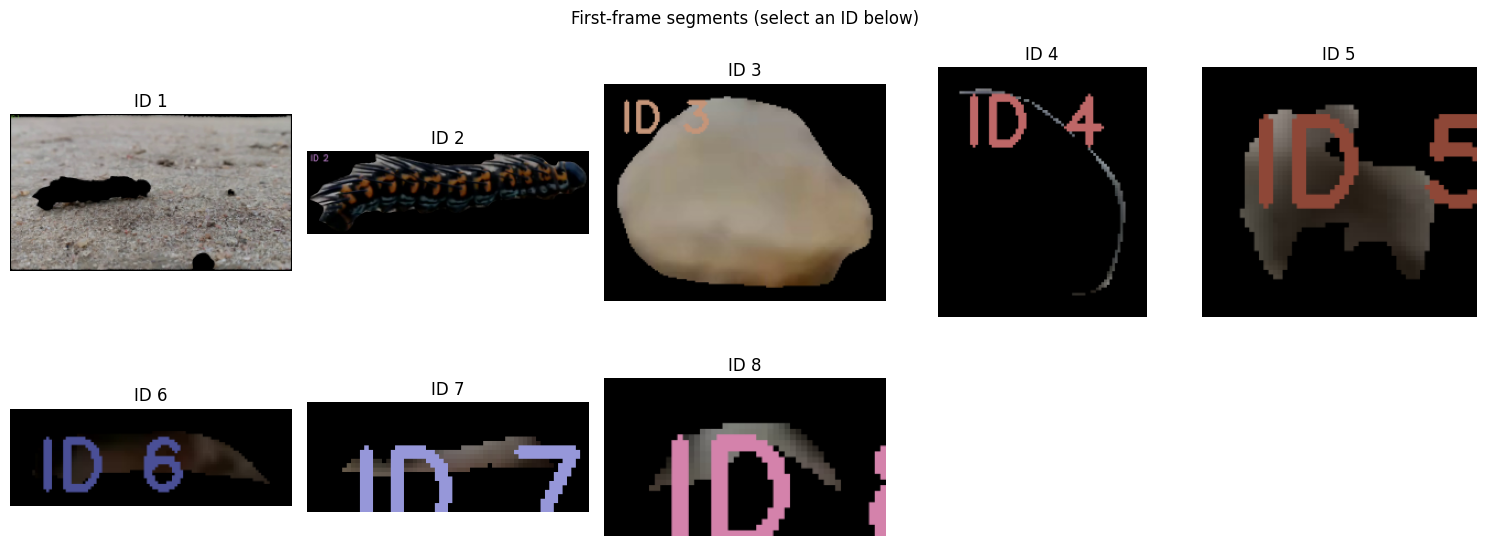

In [2]:
# Thumbnails + dropdown select one segment, then single-object XMem tracking to new overlay + masks
# Local VS Code Jupyter-ready (no Colab UI). Assumes prior cell produced:
# WORKDIR, FRAMES_DIR, FIRST_ANN_PATH, MANIFEST_JSON, XMEM_CKPT and the ./XMem repo is present.

import os, sys, json, math
import numpy as np
import cv2
from pathlib import Path

# ---- Verify prereqs from previous cell ----
vars_required = ["WORKDIR", "FRAMES_DIR", "FIRST_ANN_PATH", "MANIFEST_JSON", "XMEM_CKPT"]
missing = [v for v in vars_required if v not in globals()]
if missing:
    raise RuntimeError(f"Missing variables from previous step: {missing}. Run the previous cell first.")

if "./XMem" not in sys.path and os.path.exists("./XMem"):
    sys.path.append("./XMem")

# ---- Lightweight installs for local notebook ----
def _ensure(pkg, pip_name=None):
    try:
        __import__(pkg)
        return
    except Exception:
        import subprocess, sys as _sys
        subprocess.run([_sys.executable, "-m", "pip", "install", "-q", pip_name or pkg], check=False)

_ensure("ipywidgets", "ipywidgets")   # interactive dropdown/button
_ensure("matplotlib", "matplotlib")   # thumbnail grid

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# ---- Load metadata and first frame ----
with open(MANIFEST_JSON, "r") as f:
    manifest = json.load(f)

label_map = cv2.imread(FIRST_ANN_PATH, cv2.IMREAD_UNCHANGED)
assert label_map is not None and label_map.dtype == np.uint16, "Invalid FIRST_ANN_PATH label map."

# Frame 0
frame0 = os.path.join(FRAMES_DIR, "00000.jpg")
if not os.path.exists(frame0):
    jpgs = sorted([p for p in os.listdir(FRAMES_DIR) if p.lower().endswith(".jpg")])
    assert len(jpgs) > 0, "No frames found."
    frame0 = os.path.join(FRAMES_DIR, jpgs[0])
first_bgr = cv2.imread(frame0)
assert first_bgr is not None, f"Cannot read {frame0}"

# ---- Build segment list and thumbnails ----
segs = manifest.get("segments", [])
id_to_seg = {int(s["id"]): s for s in segs}
valid_ids = sorted([sid for sid in id_to_seg.keys() if (label_map == sid).any()])

thumbs, titles = [], []
max_side = 256
for sid in valid_ids:
    mask = (label_map == sid).astype(np.uint8)
    ys, xs = np.where(mask > 0)
    if len(xs) == 0:
        continue
    x1, x2 = int(xs.min()), int(xs.max())
    y1, y2 = int(ys.min()), int(ys.max())
    seg_bgr = cv2.bitwise_and(first_bgr, first_bgr, mask=mask*255)
    crop = seg_bgr[y1:y2+1, x1:x2+1]
    if crop.size == 0:
        continue
    pad = 8
    crop = cv2.copyMakeBorder(crop, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=(0,0,0))
    color = tuple(map(int, id_to_seg[sid].get("color_bgr", (0,255,0))))
    cv2.putText(crop, f"ID {sid}", (10, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    h, w = crop.shape[:2]
    scale = max_side / max(h, w)
    crop_resized = cv2.resize(crop, (max(1,int(w*scale)), max(1,int(h*scale))), interpolation=cv2.INTER_AREA)
    thumbs.append(crop_resized)
    titles.append(f"ID {sid}")

# ---- Display grid of thumbnails ----
if len(thumbs) > 0:
    cols = 5
    rows = max(1, math.ceil(len(thumbs) / cols))
    plt.figure(figsize=(cols*3, rows*3))
    for i, img in enumerate(thumbs):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(titles[i])
        ax.axis('off')
    plt.suptitle("First-frame segments (select an ID below)")
    plt.tight_layout()
    plt.show()
else:
    print("No thumbnails to display; check FIRST_ANN_PATH or thresholds in the previous cell.")

# ---- Widgets for selection and execution ----
dropdown = widgets.Dropdown(
    options=[(f"ID {sid}", sid) for sid in valid_ids] if valid_ids else [("None", None)],
    value=valid_ids[0] if valid_ids else None,
    description="Segment:",
    disabled=(len(valid_ids) == 0),
)
run_btn = widgets.Button(description="Run tracking", button_style="primary", tooltip="Run single-object tracking")
out = widgets.Output()
display(widgets.VBox([dropdown, run_btn, out]))

# ---- Single-object XMem tracking ----
def run_tracking(selected_id: int):
    import torch
    import torch.nn.functional as F
    from dataset.range_transform import im_normalization
    from inference.inference_core import InferenceCore
    from inference.interact.interactive_utils import index_numpy_to_one_hot_torch
    from model.network import XMem as XMemModel

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    XMEM_CFG = {
        "top_k": 50,
        "mem_every": 5,
        "deep_update_every": -1,
        "enable_long_term": True,
        "enable_long_term_count_usage": True,
        "num_prototypes": 128,
        "min_mid_term_frames": 5,
        "max_mid_term_frames": 10,
        "max_long_term_elements": 10000,
    }
    xmem = XMemModel(XMEM_CFG, XMEM_CKPT, map_location=DEVICE).eval().to(DEVICE)
    processor = InferenceCore(xmem, config=XMEM_CFG)

    # Prepare single-object init
    orig_h, orig_w = label_map.shape[:2]
    single_init = (label_map == selected_id).astype(np.int64)  # {0,1}

    scaler = max(orig_h, orig_w) / 480.0
    resized_w = int(round(orig_w / scaler))
    resized_h = int(round(orig_h / scaler))

    init_mask = torch.from_numpy(single_init).view(1,1,orig_h,orig_w).float()
    init_mask = F.interpolate(init_mask, (resized_h, resized_w), mode="nearest").squeeze(0).squeeze(0).cpu().numpy().astype(np.int64)

    # one-hot with 2 classes (bg, obj), drop bg -> shape [1,H,W]
    oh = index_numpy_to_one_hot_torch(init_mask, 2)[1:].to(DEVICE)
    processor.set_all_labels([1])  # single object label index

    # IO
    frame_files = sorted([f for f in os.listdir(FRAMES_DIR) if f.lower().endswith(".jpg")])
    SELECTED_DIR = os.path.join(WORKDIR, f"selected_id_{selected_id:03d}")
    out_labels_dir = os.path.join(SELECTED_DIR, "labels_single")
    out_masks_dir  = os.path.join(SELECTED_DIR, "masks_single")
    os.makedirs(out_labels_dir, exist_ok=True)
    os.makedirs(out_masks_dir, exist_ok=True)

    # Overlay video
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    overlay_out = os.path.join(SELECTED_DIR, f"overlay_selected_id{selected_id:03d}.mp4")
    writer = None
    color = tuple(map(int, id_to_seg[selected_id].get("color_bgr", (0,255,0))))
    fps = float(manifest.get("fps", 25.0))

    with torch.no_grad(), torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
        for i, fn in enumerate(frame_files):
            bgr = cv2.imread(os.path.join(FRAMES_DIR, fn))
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            t = torch.from_numpy(rgb).permute(2,0,1).unsqueeze(0).float() / 255.0
            t = F.interpolate(t, (resized_h, resized_w), mode="bilinear", align_corners=False)
            t = im_normalization(t).to(DEVICE)

            if i == 0:
                pred = processor.step(t[0], oh)  # init with selected object
            else:
                pred = processor.step(t[0])

            pred_idx = torch.argmax(pred, dim=0).unsqueeze(0).unsqueeze(0).to(torch.uint8)
            pred_up = F.interpolate(pred_idx.float(), (orig_h, orig_w), mode="nearest").squeeze().cpu().numpy().astype(np.uint8)

            # Save 0/1 label and 0/255 mask
            cv2.imwrite(os.path.join(out_labels_dir, f"{i:05d}.png"), (pred_up * 1).astype(np.uint8))
            sel_mask = (pred_up == 1).astype(np.uint8) * 255
            cv2.imwrite(os.path.join(out_masks_dir,  f"{i:05d}.png"), sel_mask)

            if writer is None:
                H0, W0 = bgr.shape[:2]
                writer = cv2.VideoWriter(overlay_out, fourcc, fps, (W0, H0))

            overlay = bgr.copy()
            if sel_mask.sum() > 0:
                color_img = np.zeros_like(overlay, dtype=np.uint8)
                color_img[sel_mask > 0] = color
                overlay = cv2.addWeighted(overlay, 1.0, color_img, 0.35, 0)
                ys, xs = np.where(sel_mask > 0)
                if len(xs) > 0:
                    x1, x2 = int(xs.min()), int(xs.max())
                    y1, y2 = int(ys.min()), int(ys.max())
                    cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(overlay, f"ID {selected_id}", (x1, max(0, y1 - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            writer.write(overlay)

    if writer is not None:
        writer.release()

    # Persist selection
    os.makedirs(SELECTED_DIR, exist_ok=True)
    with open(os.path.join(SELECTED_DIR, "selection.json"), "w") as f:
        json.dump({"selected_id": selected_id}, f, indent=2)

    return {
        "SELECTED_DIR": SELECTED_DIR,
        "labels_dir": out_labels_dir,
        "masks_dir": out_masks_dir,
        "overlay_out": overlay_out,
    }

# ---- Wire button ----
def _on_click(b):
    with out:
        clear_output(wait=True)
        sel = dropdown.value
        if sel is None:
            print("No valid segment to run.")
            return
        print(f"Selected ID: {sel}")
        res = run_tracking(sel)
        print("Single-object tracking complete.")
        print(f"- Selection dir: {res['SELECTED_DIR']}")
        print(f"- Labels (0/1): {res['labels_dir']}")
        print(f"- Masks (0/255): {res['masks_dir']}")
        print(f"- Overlay video: {res['overlay_out']}")

run_btn.on_click(_on_click)


In [2]:
VIDEO_PATH = "./input_i.mp4"   # Replace or upload if missing
WORKDIR = "./workdir"
FRAMES_DIR = f"{WORKDIR}/frames"
FIRST_ANN_DIR = f"{WORKDIR}/first_anns"
FIRST_ANN_PATH = f"{FIRST_ANN_DIR}/00000.png"   # uint16 label map for frame 0
LABELS_DIR = f"{WORKDIR}/labels"
MASKS_OUT_DIR = f"{WORKDIR}/per_object_masks"
MANIFEST_JSON = f"{WORKDIR}/segments_manifest.json"
FIRST_PREVIEW = f"{WORKDIR}/first_frame_labeled.png"
OVERLAY_OUT = f"{WORKDIR}/labeled_overlay.mp4"

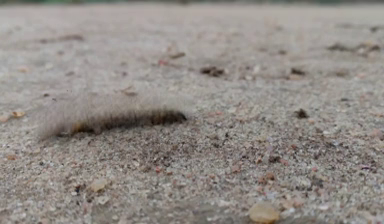

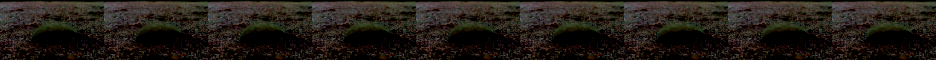

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensors in method wrapper_CUDA_cat)

In [4]:
# ProPainter-first-frame + product replacement + FramePack generation (low-VRAM, preserved_memory_gb=16)
# Uses bucket resolution=640 (as per diffusers_helper/bucket_tools.py) to avoid KeyError.

import os, sys, json, subprocess, logging, time, glob
import numpy as np
from PIL import Image
from IPython.display import clear_output, display, Image as IPyImage, Video

# --------------------- Paths and config ---------------------
PROJ = "/home/safdar/Desktop/projects/prod2vid"
WORKDIR = os.path.join(PROJ, "workdir")
FRAMEPACK_ROOT = os.path.join(PROJ, "testing_new", "FramePack")
HF_HOME = os.path.join(FRAMEPACK_ROOT, "hf_download")

PRODUCT = os.path.join(PROJ, "product.png")
SEG_MANIFEST = os.path.join(WORKDIR, "segments_manifest.json")
SELECTION = os.path.join(WORKDIR, "selected_id_002", "selection.json")

# Prefer ProPainter output if available
INPAINTED_VIDEO = os.path.join(WORKDIR, "propainter_out", "frames", "inpaint_out.mp4")
if not os.path.exists(INPAINTED_VIDEO):
    INPAINTED_VIDEO = os.path.join(WORKDIR, "propainter_out", "inpaint_out.mp4")
SRC_VIDEO = INPAINTED_VIDEO if os.path.exists(INPAINTED_VIDEO) else os.path.join(PROJ, "input_i.mp4")

EDIT_DIR = os.path.join(WORKDIR, "framepack_edit")
FIRST_DIR = os.path.join(EDIT_DIR, "edited_first")
FRAMES_DIR = os.path.join(EDIT_DIR, "frames")
os.makedirs(EDIT_DIR, exist_ok=True)
os.makedirs(FIRST_DIR, exist_ok=True)
os.makedirs(FRAMES_DIR, exist_ok=True)
FIRST_EDIT_PATH = os.path.join(FIRST_DIR, "first_edited.png")

# Controls (adjust if needed)
prompt_text = globals().get("prompt_text", "Keep motion natural and consistent with the scene.").strip()
video_seconds = float(globals().get("video_seconds", 5.0))
steps = int(globals().get("steps", 25))
seed = int(globals().get("seed", 31337))
use_teacache = True
mp4_crf = 16
bucket_resolution = 640            # IMPORTANT: valid per bucket_tools.py
preserved_memory_gb = 16.0         # Requested value

# Environment: local HF cache; avoid xet transfer URLs
os.environ["HF_HOME"] = HF_HOME
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"
os.environ["HF_HUB_HTTP_TIMEOUT"] = "60"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Import FramePack code
sys.path.append(FRAMEPACK_ROOT)

# --------------------- Logging ---------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s", datefmt="%H:%M:%S")
log = logging.getLogger("fp_pipeline")

def gpu_info():
    try:
        out = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.used,memory.total,utilization.gpu", "--format=csv,noheader,nounits"]
        ).decode().strip().splitlines()
        used, total, util = out[0].split(",")
        return f"GPU {used.strip()}/{total.strip()} MiB, util {util.strip()}%"
    except Exception:
        return "GPU info unavailable"

# --------------------- Step 1: first frame (ProPainter preferred) ---------------------
import cv2
log.info(f"Source video: {SRC_VIDEO} ({'ProPainter inpainted' if 'inpaint_out' in SRC_VIDEO else 'original'})")
cap = cv2.VideoCapture(SRC_VIDEO)
ok, first_bgr = cap.read()
cap.release()
assert ok and first_bgr is not None, f"Failed to read first frame from {SRC_VIDEO}"
first_rgb = cv2.cvtColor(first_bgr, cv2.COLOR_BGR2RGB)
H, W, _ = first_rgb.shape
log.info(f"First frame shape: {W}x{H}")

# --------------------- Step 2: bbox from selection/manifest ---------------------
with open(SELECTION, "r") as f:
    sel_id = json.load(f).get("selected_id", 2)
with open(SEG_MANIFEST, "r") as f:
    manifest = json.load(f)

bbox = None
for seg in manifest.get("segments", []):
    if seg.get("id") == sel_id:
        bbox = seg.get("bbox_xyxy")
        break
assert bbox is not None, f"Selected id {sel_id} not found in segments_manifest.json"
x1, y1, x2, y2 = [int(v) for v in bbox]
x1, y1 = max(0, x1), max(0, y1)
x2, y2 = min(W-1, x2), min(H-1, y2)
bw, bh = (x2 - x1 + 1), (y2 - y1 + 1)
log.info(f"Selected ID: {sel_id} | BBox: {(x1,y1,x2,y2)} size={bw}x{bh}")

# --------------------- Step 3: product replacement on first frame ---------------------
prod = Image.open(PRODUCT).convert("RGBA")
pw, ph = prod.size
log.info(f"Product: {PRODUCT} size={pw}x{ph}")

canvas = Image.fromarray(first_rgb).convert("RGBA")
margin = 0.06
scale = max(1e-3, min(bw / pw, bh / ph) * (1.0 - margin))
nw, nh = max(1, int(round(pw * scale))), max(1, int(round(ph * scale)))
dst_x, dst_y = x1 + (bw - nw) // 2, y1 + (bh - nh) // 2
log.info(f"Pasting product at {(dst_x, dst_y)} scaled to {nw}x{nh}")
canvas.alpha_composite(prod.resize((nw, nh), Image.LANCZOS), (dst_x, dst_y))
edited_first_rgb = np.array(canvas.convert("RGB"))
Image.fromarray(edited_first_rgb).save(FIRST_EDIT_PATH)
log.info(f"Saved edited first frame: {FIRST_EDIT_PATH}")
display(IPyImage(filename=FIRST_EDIT_PATH))

# --------------------- Step 4: FramePack (low-VRAM) ---------------------
import torch, einops
from diffusers import AutoencoderKLHunyuanVideo
from transformers import (
    LlamaModel, CLIPTextModel, LlamaTokenizerFast, CLIPTokenizer,
    SiglipVisionModel, SiglipImageProcessor
)
from diffusers_helper.hunyuan import encode_prompt_conds, vae_decode, vae_encode, vae_decode_fake
from diffusers_helper.utils import (
    save_bcthw_as_mp4, crop_or_pad_yield_mask, soft_append_bcthw, resize_and_center_crop, generate_timestamp
)
from diffusers_helper.models.hunyuan_video_packed import HunyuanVideoTransformer3DModelPacked
from diffusers_helper.pipelines.k_diffusion_hunyuan import sample_hunyuan
from diffusers_helper.memory import (
    cpu, gpu, get_cuda_free_memory_gb,
    move_model_to_device_with_memory_preservation, offload_model_from_device_for_memory_preservation,
    fake_diffusers_current_device, DynamicSwapInstaller, unload_complete_models, load_model_as_complete
)
from diffusers_helper.bucket_tools import find_nearest_bucket

free_mem_gb = get_cuda_free_memory_gb(gpu)
log.info(f"Free VRAM: {free_mem_gb:.2f} GB | {gpu_info()}")

# Load models on CPU (low-VRAM mode)
log.info("Loading models on CPU...")
text_encoder   = LlamaModel.from_pretrained("hunyuanvideo-community/HunyuanVideo", subfolder='text_encoder',   torch_dtype=torch.float16).cpu()
text_encoder_2 = CLIPTextModel.from_pretrained("hunyuanvideo-community/HunyuanVideo", subfolder='text_encoder_2', torch_dtype=torch.float16).cpu()
tokenizer      = LlamaTokenizerFast.from_pretrained("hunyuanvideo-community/HunyuanVideo", subfolder='tokenizer')
tokenizer_2    = CLIPTokenizer.from_pretrained("hunyuanvideo-community/HunyuanVideo", subfolder='tokenizer_2')
vae            = AutoencoderKLHunyuanVideo.from_pretrained("hunyuanvideo-community/HunyuanVideo", subfolder='vae', torch_dtype=torch.float16).cpu()
feature_extractor = SiglipImageProcessor.from_pretrained("lllyasviel/flux_redux_bfl", subfolder='feature_extractor')
image_encoder  = SiglipVisionModel.from_pretrained("lllyasviel/flux_redux_bfl", subfolder='image_encoder', torch_dtype=torch.float16).cpu()
transformer    = HunyuanVideoTransformer3DModelPacked.from_pretrained('lllyasviel/FramePackI2V_HY', torch_dtype=torch.bfloat16).cpu()

vae.eval(); text_encoder.eval(); text_encoder_2.eval(); image_encoder.eval(); transformer.eval()
vae.enable_slicing(); vae.enable_tiling()
transformer.high_quality_fp32_output_for_inference = True
transformer.to(dtype=torch.bfloat16)
vae.to(dtype=torch.float16)
image_encoder.to(dtype=torch.float16)
text_encoder.to(dtype=torch.float16)
text_encoder_2.to(dtype=torch.float16)

# Install dynamic swap (mirrors demo_gradio.py)
DynamicSwapInstaller.install_model(transformer, device=gpu)
DynamicSwapInstaller.install_model(text_encoder, device=gpu)
log.info(f"Models prepared. {gpu_info()}")

# Prepare inputs with bucket resolution=640
height, width = find_nearest_bucket(*edited_first_rgb.shape[:2], resolution=bucket_resolution)
input_image_np = resize_and_center_crop(edited_first_rgb, target_width=width, target_height=height)
Image.fromarray(input_image_np).save(os.path.join(EDIT_DIR, "edited_first_frame_resized.png"))

input_image_pt = torch.from_numpy(input_image_np).float() / 127.5 - 1
input_image_pt = input_image_pt.permute(2, 0, 1)[None, :, None]

# Encode prompts
log.info("Encoding prompts...")
fake_diffusers_current_device(text_encoder, gpu)    # swapped encoder
load_model_as_complete(text_encoder_2, target_device=gpu)
llama_vec, clip_l_pooler = encode_prompt_conds(prompt_text, text_encoder, text_encoder_2, tokenizer, tokenizer_2)
llama_vec_n, clip_l_pooler_n = torch.zeros_like(llama_vec), torch.zeros_like(clip_l_pooler)  # cfg == 1
llama_vec, llama_attention_mask = crop_or_pad_yield_mask(llama_vec, length=512)
llama_vec_n, llama_attention_mask_n = crop_or_pad_yield_mask(llama_vec_n, length=512)

# VAE encode first frame
log.info("VAE encode edited first frame...")
load_model_as_complete(vae, target_device=gpu)
start_latent = vae_encode(input_image_pt.to(vae.device, dtype=torch.float16), vae)

# CLIP Vision encode
log.info("CLIP vision encode...")
load_model_as_complete(image_encoder, target_device=gpu)
img_inputs = feature_extractor(images=Image.fromarray(input_image_np), return_tensors="pt").to(image_encoder.device, dtype=image_encoder.dtype)
image_encoder_output = image_encoder(**img_inputs)
image_encoder_last_hidden_state = image_encoder_output.last_hidden_state

# Cast to transformer dtype
llama_vec = llama_vec.to(transformer.dtype)
llama_vec_n = llama_vec_n.to(transformer.dtype)
clip_l_pooler = clip_l_pooler.to(transformer.dtype)
clip_l_pooler_n = clip_l_pooler_n.to(transformer.dtype)
image_encoder_last_hidden_state = image_encoder_last_hidden_state.to(transformer.dtype)

# Free encoders + VAE until needed
unload_complete_models(text_encoder, text_encoder_2, image_encoder, vae)
torch.cuda.empty_cache()

# Sampling config (same pattern as demo_gradio.py)
latent_window_size = 9
frames_per_section = latent_window_size * 4 - 3
total_sections = int(max(round((video_seconds * 30) / (latent_window_size * 4)), 1))
latent_paddings = list(reversed(range(total_sections)))
if total_sections > 4:
    latent_paddings = [3] + [2] * (total_sections - 3) + [1, 0]

from diffusers_helper.utils import generate_timestamp
import einops
rnd = torch.Generator("cpu").manual_seed(seed)
history_latents = torch.zeros(size=(1, 16, 1 + 2 + 16, height // 8, width // 8), dtype=torch.float32).cpu()
history_pixels = None
total_generated_latent_frames = 0
job_id = generate_timestamp()
latest_video_path = None

log.info(f"Start sampling | sections={total_sections}, frames/section={frames_per_section}, steps={steps}, teacache={use_teacache}, preserved_memory_gb={preserved_memory_gb}")

def save_preview_latent(d, tag):
    try:
        pr = vae_decode_fake(d['denoised'])
        pr = (pr * 255.0).detach().cpu().numpy().clip(0, 255).astype(np.uint8)
        tiled = einops.rearrange(pr, "b c t h w -> (b h) (t w) c")
        p = os.path.join(FRAMES_DIR, f"latent_{tag}.png")
        Image.fromarray(tiled).save(p)
        return p
    except Exception as e:
        log.warning(f"Preview latent save failed: {e}")
        return None

for s_idx, latent_padding in enumerate(latent_paddings):
    is_last_section = latent_padding == 0
    latent_padding_size = latent_padding * latent_window_size
    log.info(f"[Section {s_idx+1}/{len(latent_paddings)}] padding={latent_padding} ({latent_padding_size}) | {gpu_info()}")

    indices = torch.arange(0, sum([1, latent_padding_size, latent_window_size, 1, 2, 16])).unsqueeze(0)
    clean_latent_indices_pre, blank_indices, latent_indices, clean_latent_indices_post, clean_latent_2x_indices, clean_latent_4x_indices = indices.split(
        [1, latent_padding_size, latent_window_size, 1, 2, 16], dim=1
    )
    clean_latent_indices = torch.cat([clean_latent_indices_pre, clean_latent_indices_post], dim=1)

    clean_latents_pre = start_latent.to(history_latents)
    clean_latents_post, clean_latents_2x, clean_latents_4x = history_latents[:, :, :1 + 2 + 16, :, :].split([1, 2, 16], dim=2)
    clean_latents = torch.cat([clean_latents_pre, clean_latents_post], dim=2)

    # Move transformer to GPU with preserved_memory_gb=16
    unload_complete_models()
    move_model_to_device_with_memory_preservation(transformer, target_device=gpu, preserved_memory_gb=preserved_memory_gb)

    transformer.initialize_teacache(enable_teacache=use_teacache, num_steps=steps)

    def callback(d):
        step_i = d['i'] + 1
        if step_i == 1 or step_i % max(1, steps // 5) == 0 or step_i == steps:
            log.info(f"  - Sampling step {step_i}/{steps} | {gpu_info()}")
            pv = save_preview_latent(d, f"s{s_idx+1}_st{step_i}")
            if pv:
                clear_output(wait=True)
                display(IPyImage(filename=FIRST_EDIT_PATH))
                display(IPyImage(filename=pv))

    generated_latents = sample_hunyuan(
        transformer=transformer,
        sampler='unipc',
        width=width,
        height=height,
        frames=frames_per_section,
        real_guidance_scale=1.0,
        distilled_guidance_scale=10.0,
        guidance_rescale=0.0,
        num_inference_steps=steps,
        generator=rnd,
        prompt_embeds=llama_vec,
        prompt_embeds_mask=llama_attention_mask,
        prompt_poolers=clip_l_pooler,
        negative_prompt_embeds=llama_vec_n,
        negative_prompt_embeds_mask=llama_attention_mask_n,
        negative_prompt_poolers=clip_l_pooler_n,
        device=gpu,
        dtype=torch.bfloat16,
        image_embeddings=image_encoder_last_hidden_state,
        latent_indices=latent_indices,
        clean_latents=clean_latents,
        clean_latent_indices=clean_latent_indices,
        clean_latents_2x=clean_latents_2x,
        clean_latent_2x_indices=clean_latent_2x_indices,
        clean_latents_4x=clean_latents_4x,
        clean_latent_4x_indices=clean_latent_4x_indices,
        callback=callback,
    )

    if is_last_section:
        generated_latents = torch.cat([start_latent.to(generated_latents), generated_latents], dim=2)

    total_generated_latent_frames += int(generated_latents.shape[2])
    history_latents = torch.cat([generated_latents.to(history_latents.dtype), history_latents], dim=2)

    # Offload transformer and decode with VAE (preserve 16 GB)
    offload_model_from_device_for_memory_preservation(transformer, target_device=gpu, preserved_memory_gb=preserved_memory_gb)
    load_model_as_complete(vae, target_device=gpu)

    real_history_latents = history_latents[:, :, :total_generated_latent_frames, :, :]
    if 'history_pixels' not in globals() or globals().get('history_pixels') is None:
        history_pixels = vae_decode(real_history_latents, vae).cpu()
    else:
        section_latent_frames = (latent_window_size * 2 + 1) if is_last_section else (latent_window_size * 2)
        overlapped_frames = latent_window_size * 4 - 3
        current_pixels = vae_decode(real_history_latents[:, :, :section_latent_frames], vae).cpu()
        history_pixels = soft_append_bcthw(current_pixels, history_pixels, overlapped_frames)

    unload_complete_models(vae)

    # Save last frame and MP4
    b, c, t, h, w = history_pixels.shape
    last = history_pixels[0, :, t-1, :, :].permute(1, 2, 0).numpy()
    last = (np.clip(last, 0.0, 1.0) * 255).astype(np.uint8)
    frame_path = os.path.join(FRAMES_DIR, f"frame_{t:05d}.png")
    Image.fromarray(last).save(frame_path)

    latest_video_path = os.path.join(EDIT_DIR, f'{generate_timestamp()}_{total_generated_latent_frames}.mp4')
    save_bcthw_as_mp4(history_pixels, latest_video_path, fps=30, crf=mp4_crf)
    log.info(f"Saved: {latest_video_path} | frames={t} | last_frame={os.path.basename(frame_path)} | {gpu_info()}")

    clear_output(wait=True)
    display(IPyImage(filename=FIRST_EDIT_PATH))
    display(IPyImage(filename=frame_path))
    display(Video(latest_video_path, embed=True))

log.info("Generation complete.")
if latest_video_path:
    log.info(f"Final video: {latest_video_path}")
log.info(f"Frames: {FRAMES_DIR}")